/home/jovyan/.local/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.11, the latest is 0.5.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


Used Feature columns: ['MR_accpre', 'WM_Zpre', 'IC_Zreverse_pre', 'NT_Zpre', 'TCA_Zscore', 'CFQMALscore', 'Avg_grit_amb', 'NEOFFIExtraversion', 'NEOFFIAgreeableness', 'NEOFFIConscientiousness', 'NEOFFIEmotionalstability', 'NEOFFIIntellectorOpenness', 'VGQHoursCategorySumPastYear_Z', 'ParentalEducationSum', 'SelfReportedSESRatingSum', 'Physicalhealth', 'Physicalfitness', 'Psychohealth', 'Gamified', 'Difficulty', 'Bilingual']
The sample size of raw data is 949.
The sample size of no missing data (listwise) is 568.
Categorical Gamified information:Gamified
Gamified       315
Nongamified    253
dtype: int64
Categorical Difficulty information:Difficulty
Difficult     50
Middle       181
Moderate     169
hard         150
dtype: int64
Categorical Bilingual information:Bilingual
Bilingual      403
Monolingual    103
dtype: int64


In [2]:
# clean intervention data (delete outliers)
int_test = idp.InterventionProcessor(data_nomissing_training)
int_test.basic_analyze()
int_test.mark_outlier_stewd(['std','mean'])
int_test.delete_outlier()

The average maximun span across sessions is 5.157 with sd 5.815
The average standard deviation across sessions is 0.874 with sd 1.782
The average span across sessions is 3.920 with sd 3.733
The skew of std is 7.766
std:MC=0.193
interval of std is 2.6941854040225532 to -0.15348068866153236
     Unique  mean_1  mean_2  mean_3  mean_4  mean_5  mean_6  mean_7  mean_8  \
33       34   4.140   6.510   9.100   7.920   9.050   9.130   8.830  13.560   
41       42   4.150   7.010  18.550  29.390  38.250  43.580  49.000  51.500   
44       45   2.530   2.420   2.770   3.070   2.550   2.780   2.740   3.550   
147     148   2.510   3.010   3.520   3.960   5.700   7.230   8.600  10.450   
472     473   3.000   3.000   4.000   4.000   6.000   7.000   9.000  10.000   
505     506   4.000   7.000   9.000   8.000   9.000   9.000   9.000  14.000   
582     583   3.000   2.000   3.000   3.000   3.000   3.000   3.000   4.000   
583     584   4.000   7.000  19.000  29.000  38.000  44.000  49.000  52.000   

In [3]:
#using regressor to fit individual training data
piece_lin_reg = reg.PiecewiselinRegressor(['knot', 'slope1', 'slope2','turning_value'])
log_lin_reg = reg.LogRegressor(['log_slope', 'log_bias'])
lin_reg = reg.LinearRegressor(['linear_slope', 'linear_bias'])

# ['knot','slope1','slope2','std','max','r2','turning_value']
# ['linear_slope', 'linear_bias']
int_test.register_regressor(piece_lin_reg)
int_test.fit()
# plot.plot_distribution(int_test.data, ['knot','slope1','slope2','std','max','r2'])

The average r2 for <class 'regressor.PiecewiselinRegressor'> is: 0.728
The num of objects can not fit by pwlf: Unique            0
mean_1            0
mean_2            0
mean_3            0
mean_4            0
mean_5            0
mean_6            0
mean_7            0
mean_8            0
mean_9            0
mean_10           0
max               0
std               0
mean              0
outlier           0
knot             42
slope1           42
slope2           42
turning_value    42
r2               42
dtype: int64
The sample size that can fit with pwlf: 506


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


The silhouette score of KMeans(n_clusters=3, random_state=0) is: 0.472
The Davies-Bouldin score of KMeans(n_clusters=3, random_state=0) is: 0.749
Sample of each cluster: Kmeans_3
0     45
1    235
2    226
dtype: int64


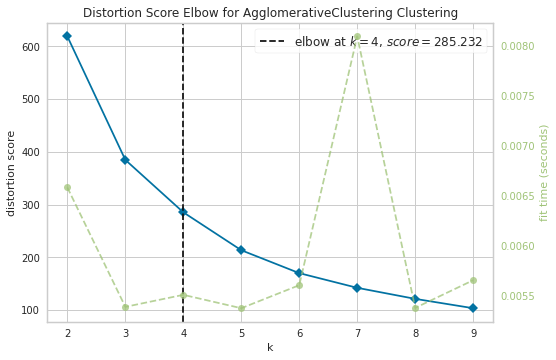

The cluster centers are: [[ 0.93787341 -0.42673683]
 [-0.77857155  0.00440837]
 [-1.02576723  2.21595575]]
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


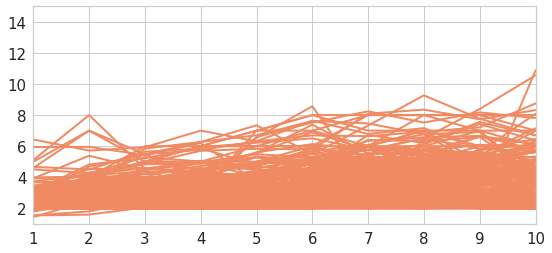

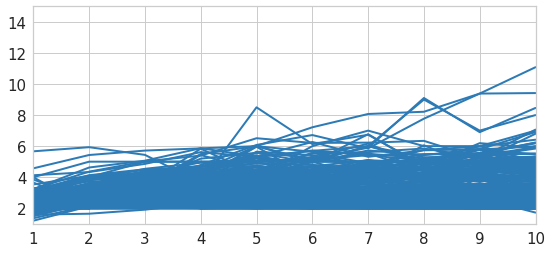

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


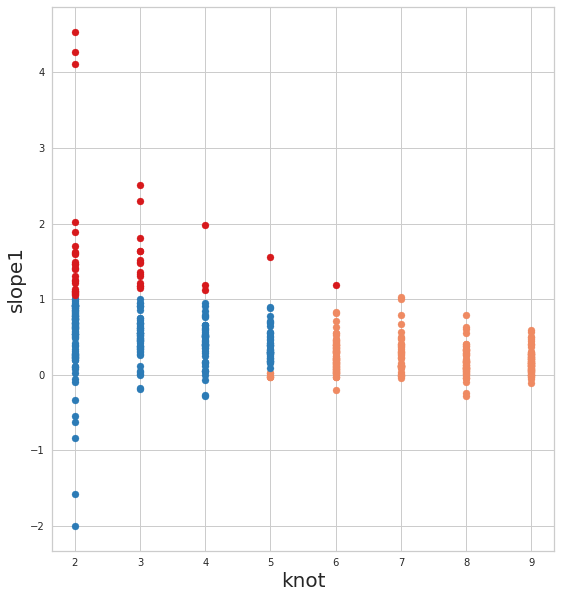

In [5]:
# Assign labels to clusters
naming_dict = {0:'much_benefit', 1:'less_benefit', 2:'less_benefit'}
int_test.create_labels(dict_naming=naming_dict, cluster_col='Kmeans_3', delete1cluster=False, cluster_delete=None)

## Feature preprocessing

In [6]:
# Feature preprocessing
import feature_preprocessor as fp
fp_test = fp.FeatureProcessor(data_nomissing_training,add_demographic=False)
fp_test.delete_missing_rows(8)
fp_test.make_dummy()

Original length of data is : 568
Delete rows have >= crtieria missing values in features
The data length now is :527


## Classification preprocessing

In [7]:
import classification_preprocessor as cp
cp_test = cp.ClassifyPreprocessor(int_test.data, fp_test.data, label_name='Kmeans_3')

In [11]:
### split train and test set
df_train, df_test = cp_test.split_train_test()
### get mean and std of original train set
mean_train_num, std_train_num = cp_test.get_mean_std(df_train)
### impute train set
df_train_imputed = cp_test.features_impute_missing(df_train)
### standardize train and test set
df_train_scaled, df_test_scaled = cp_test.standardize_numerical(df_train_imputed, df_test, 
                                                                         mean_train_num, std_train_num)

The length of training set before resample: 374
The length of test set: 94
The sample weight of train set before resample: Counter({'less_benefit': 342, 'much_benefit': 32})
The sample weight of test set: Counter({'less_benefit': 86, 'much_benefit': 8})
============Finish split train and test set=============
Feature NEOFFIIntellectorOpenness missing counts: 0(0.0 %)
Feature SelfReportedSESRatingSum missing counts: 0(0.0 %)
Feature NEOFFIAgreeableness missing counts: 0(0.0 %)
Feature NEOFFIExtraversion missing counts: 0(0.0 %)
Feature NEOFFIEmotionalstability missing counts: 0(0.0 %)
Feature TCA_Zscore missing counts: 0(0.0 %)
Feature CFQMALscore missing counts: 0(0.0 %)
Feature WM_Zpre missing counts: 1(0.3 %)
Feature NEOFFIConscientiousness missing counts: 0(0.0 %)
Feature VGQHoursCategorySumPastYear_Z missing counts: 1(0.3 %)
============Finish impute missing values in features=============
The sample weight after resample: Counter({'less_benefit': 342, 'much_benefit': 342})
=======

ValueError: operands could not be broadcast together with shapes (684,10) (18,) 

In [ ]:
### feature selection
cp_test.feature_selection(df_train_scaled, 10)

In [9]:
### resample train set
resample_dict = {'less_benefit':342, 'much_benefit':342}
features_resample, labels_resample = cp_test.resample_train(df_train_scaled, resample_dict, oversample=True

NEOFFIIntellectorOpenness 0.39397032341921334
SelfReportedSESRatingSum 0.3849491966710812
NEOFFIAgreeableness 0.3849123939478314
NEOFFIExtraversion 0.379290153435889
NEOFFIEmotionalstability 0.35679930583174846
TCA_Zscore 0.35335783826068834
CFQMALscore 0.3359109161471361
WM_Zpre 0.3342291742114283
NEOFFIConscientiousness 0.3335372544058426
VGQHoursCategorySumPastYear_Z 0.31235228571945406
MR_accpre 0.28703599531624624
Psychohealth 0.2618050730294219
Physicalfitness 0.22410918142043745
ParentalEducationSum 0.21127715088975751
Difficulty_Middle 0.18192694493100658
Physicalhealth 0.18045782482070805
Gamified_Nongamified 0.17313565110781437
Gamified_Gamified 0.14121072354137665
Difficulty_Moderate 0.1405547440139001
Avg_grit_amb 0.13255887252961474
Difficulty_hard 0.12615802721648373
Bilingual_Bilingual 0.12434506694251013
Bilingual_Monolingual 0.12342172850457467
NT_Zpre 0.11417309030588862
IC_Zreverse_pre 0.0975156946181237
Difficulty_Difficult 0.08049995878802174
The top 10 features ar

In [10]:
saved_data_path = path.join(data_folder_loc, 'saved data/2022/April/kmeans_binary_sdand')
cp_test.save_data(features_resample, labels_resample, df_test_scaled, saved_data_path)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=5c9e1ba2-0cb9-40ed-a01b-b56de82eb464' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>